# The transient Universe


### Tasks

**Remember this is a real research example, not an exam! You're welcome (and encouraged actually!) to use all the tutorials/answers/hack you find online!**


1) Read in `solutions/transient.npy`. This is a (10 x 3) numpy array, containing some time-series measurements from a transient phenomenon. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC sampler that we looked at in class (`emcee`, `pymc3`), perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) For each parameter, find the median and 90% credible region of the marginalized distribution and quote results as, for instance, $t_0=X^{+Y}_{-Z}$ 




## Part 1: Emcee usage

In [20]:
import emcee
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

In [21]:
filename = "../solutions/transient.npy"

In [22]:
data = np.load(filename)

In [23]:
times = np.array(data[:, 0])
flux = np.array(data[:, 1])
err_flux = np.array(data[:, 2])

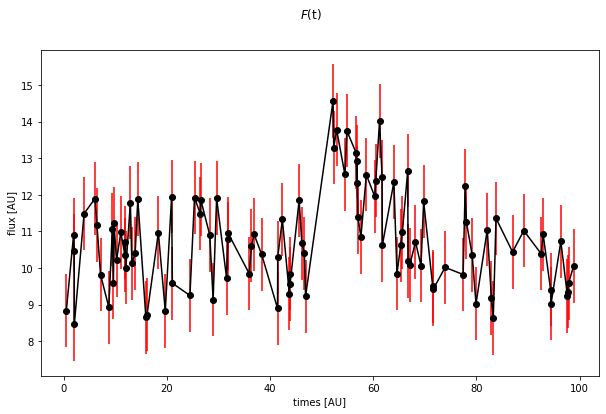

In [217]:
plt.figure(figsize=(10, 6))
plt.errorbar(times, flux, err_flux, c='k', ecolor='red', marker='o')
plt.xlabel("times [AU]")
plt.ylabel("flux [AU]")
plt.suptitle("$F$(t)");

# brutal eyeballing of the initial guesses 
#myt=np.linspace(0,100,100)
#mym =Model([10,5,50,-2], myt)
#plt.plot(myt,mym)

In [172]:
def log_Prior(par):
    
    b, A, t0, ln_alpha = par
    
    if b < 0 or b > 50 or A < 0 or A > 50 or t0 < 0 or t0 > 100 or ln_alpha < -5 or ln_alpha > 5: 
        return -np.inf
    
    else:
        return -np.log(50 * 50 * 100 * 10) 
    
    
def Model(par, t):
    
    b, A, t0, ln_alpha = par
    
    model = []
    
    for i in range(0, len(t)): 
    
        if t[i] < t0:
        
            model.append(b)
    
        if t[i] >= t0:
        
            model.append(b + A * np.exp(- np.exp(ln_alpha) * (t[i] - t0)))
            
    return model
    

def log_Likelihood(par, times, flux, err_flux):
    
    model = Model(par, times)
    
    return - 0.5 * np.sum(np.log(2*np.pi*err_flux**2) + ((flux - model) / err_flux)**2)

In [173]:
def log_Posterior (par, times, flux, err_flux):
    
    lp = log_Prior(par)
    
    if np.isfinite(lp):
        return lp + log_Likelihood(par, times, flux, err_flux)
    
    else:
        return lp

Moving onto $\textit{emcee}$: 

In [174]:
ndim = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps = 100000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses =  np.array([10,5,50,-2]) + 1e-2 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_Posterior, args=(times, flux, err_flux))
sampler.run_mcmc(starting_guesses, nsteps, progress=True);

100%|██████████████████████████████████| 100000/100000 [06:31<00:00, 255.52it/s]


Here I am showing the complete $\textit{traceplots}$ for each parameter: 

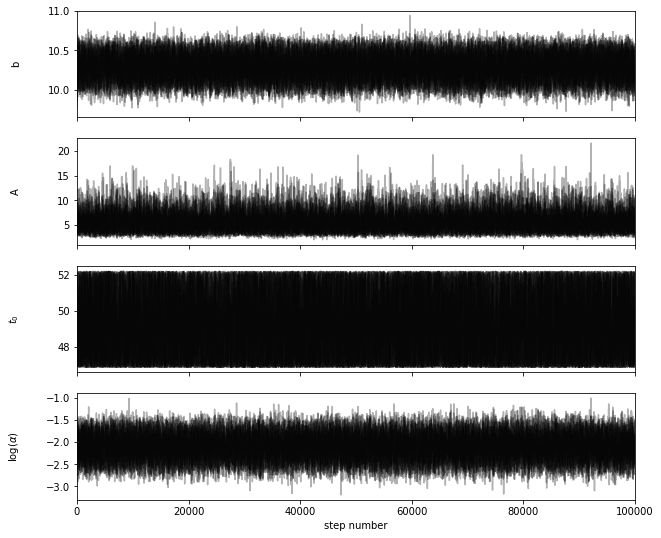

In [238]:
fig, axes = plt.subplots(4, figsize=(10, 9), sharex=True)

samples = sampler.get_chain()

labels = ["b", "A", r"$t_0$", r"log($\alpha$)"]

for i in range(0, ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], c="k", alpha=0.3)
    ax.set_xlim(0, 100000)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Evaluating the $\textit{autocorrelation time}$ and selecting accordingly: 

In [178]:
tau = sampler.get_autocorr_time()
print(tau)

[ 68.04200062 105.65129126  91.30608773  78.46527933]


Setting the $\textit{burn}$ and $\textit{thinning}$ parameter (the thinning is just for me to understand how the "thinning" process works): 

In [179]:
burn = 1000  # "burn-in" period to let chains stabilize
thinning_p = tau  # different for each array

In [180]:
sampler.chain[1, 56, 2] # 1st index = values, 2nd index = n_walkers, 3rd index = ndim

49.25786532740208

In [181]:
flat_samples = sampler.get_chain(discard=burn, thin=int(np.max(tau)), flat=True)
print(flat_samples.shape)

(9420, 4)


In [182]:
import corner
import emcee
import time

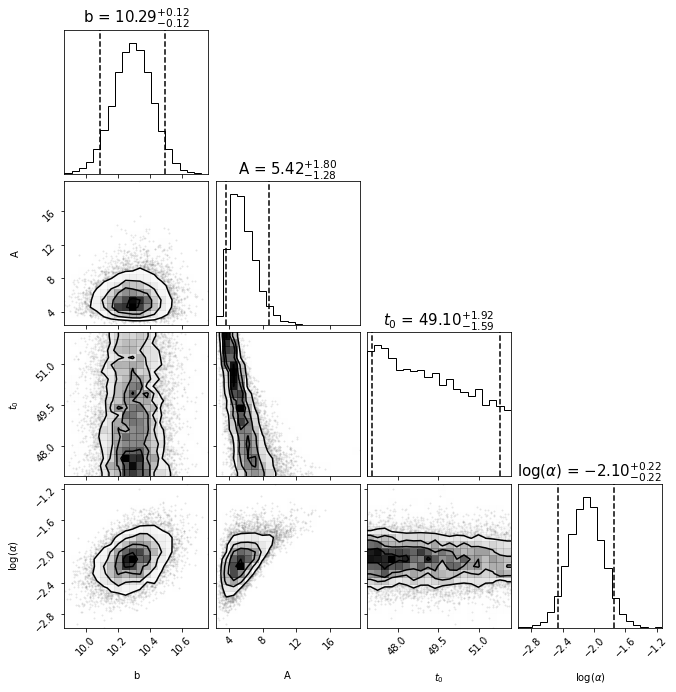

In [264]:
fig = corner.corner(
    flat_samples, labels=labels, quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}
);

I now try to do some statistics on the parameters: I will extract the $\textit{median}$ and $\textit{credibility regions}$ and print them nicely.

In [254]:
from IPython.display import display, Math, Latex

labels_output = ["b", "A", "t_0", r"log(\alpha)"]

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])  # median is 50 percentile
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels_output[i])

    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Let's now see how the posterior spread of model solutions that are consistent with the data. I will choose $100$ samples randomly from the burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data.

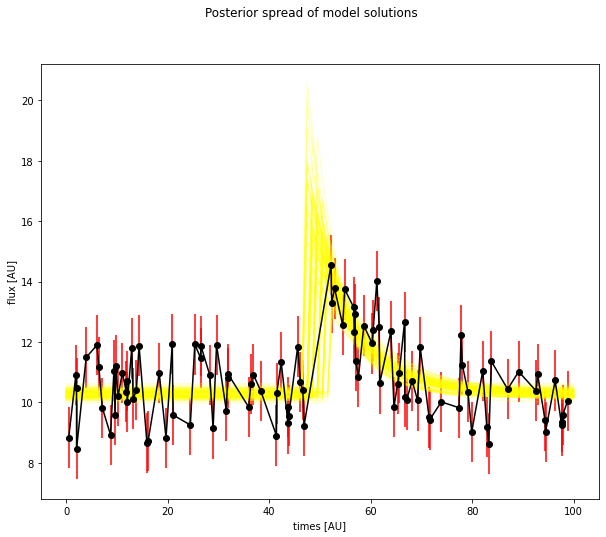

In [268]:
times_plot = np.linspace(0,100,100)

#plot section:

plt.figure(figsize=(10, 8))
plt.errorbar(times, flux, err_flux, marker='o', c="k", ecolor='red')
plt.xlabel("times [AU]")
plt.ylabel("flux [AU]")
plt.suptitle("Posterior spread of model solutions");


for i in range(0, 100): 
    
    chosen_post = int(stats.uniform.rvs(0, len(flat_samples)))
    my_Model = Model(flat_samples[chosen_post], myt)
    
    plt.plot(times_plot, my_Model, alpha=0.2, c='yellow')

I have no idea whether this is the right way to see it, but I am going to ask.

## Part 2: Nested sampling and model comparison

8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [185]:
import dynesty

In [284]:
# Define the dimensionality of the problem
ndim = 4

#define the TRANSFORM for the uniform prior:

def ptform(theta):
    
    b, A, t0, ln_alpha = theta # unpack the parameters
    
    bmin = 0.  # lower bound on uniform prior on b
    bmax = 50.   # upper bound on uniform prior on b
    
    Amin = 0.  # lower bound on uniform prior on A
    Amax = 50.   # upper bound on uniform prior on A
    
    t0min = 0.  # lower bound on uniform prior on t0
    t0max = 100.   # upper bound on uniform prior on t0
    
    lnamin = -5.  # lower bound on uniform prior on ln_a
    lnamax = 5.   # upper bound on uniform prior on ln_a

    return (b*(bmax-bmin) + bmin, A*(Amax-Amin) + A, t0*(t0max-t0min) + t0min, ln_alpha*(lnamax-lnamin) + lnamin)

In [346]:
def loglikelihood_dynesty(theta):
    """
    The log-likelihood function.
    """
    return - 0.5 * np.sum(np.log(2*np.pi*err_flux**2) + ((flux - Model(theta, times)) / err_flux)**2)

In [379]:
sampler = dynesty.NestedSampler(loglikelihood_dynesty, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

7735it [02:49, 45.69it/s, +500 | bound: 180 | nc: 1 | ncall: 171095 | eff(%):  4.827 | loglstar:   -inf < -140.657 <    inf | logz: -155.342 +/-  0.168 | dlogz:  0.001 >  0.509]


In [348]:
logZdynesty = sresults.logz[-1]        # value of logZ
logZerrdynesty = sresults.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [349]:
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty, logZerrdynesty))

Marginalised evidence (using static sampler) is -155.37271263523695 ± 0.29851845940934263


I plot parameter traces and 1-D marginalized posteriors. On the left panels, I see that the live points started out scattered across the prior volume, then move inwards as the sampler climbs the likelihood.

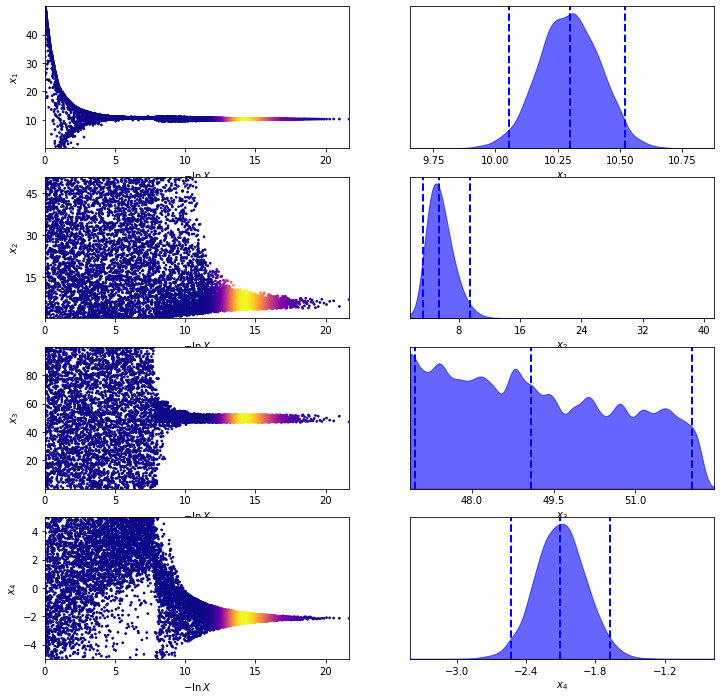

In [389]:
from dynesty import plotting as dyplot
tfig, taxes = dyplot.traceplot(sresults)

Now we get to the posterior samples: 

In [350]:
from dynesty.utils import resample_equal

In [351]:
weights = np.exp(sresults['logwt'] - sresults['logz'][-1])
postsamples = resample_equal(sresults.samples, weights)

In [352]:
print('Number of posterior samples (using static sampler) is {}'.format(postsamples.shape[0]))

Number of posterior samples (using static sampler) is 8254


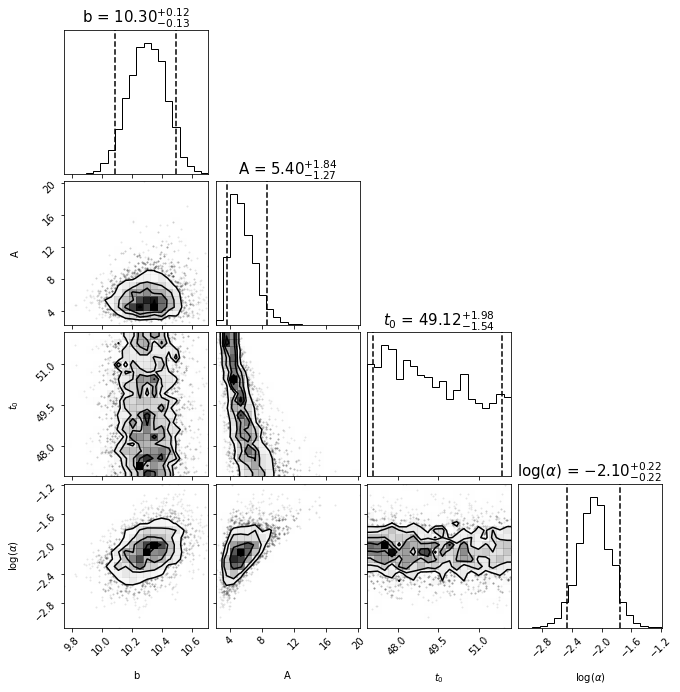

In [353]:
fig = corner.corner(
    postsamples, labels=labels, quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}
);

Okay, now we come to the best part of all: understanding what we did here and fix the code accordingly in case there are some mistakes. 

I'm going to see the model solution though: maybe it will give me some hints. 

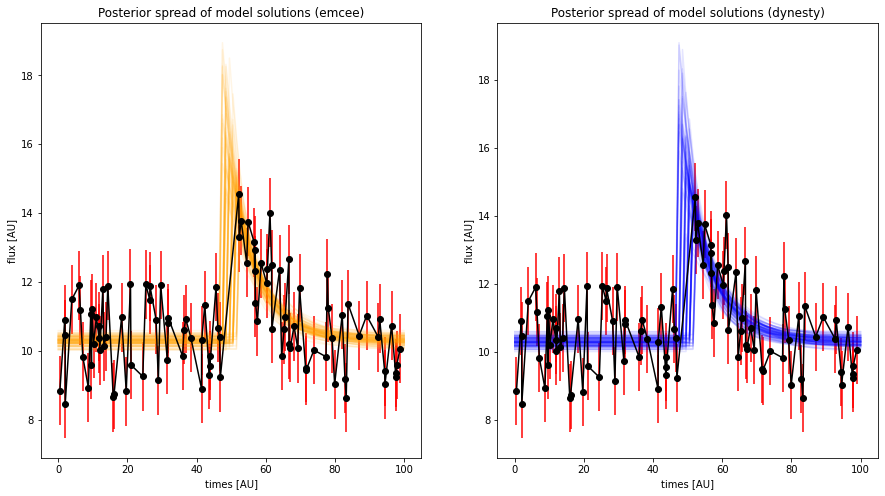

In [354]:
times_plot = np.linspace(0,100,100)

#plot section:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

ax1.errorbar(times, flux, err_flux, marker='o', c="k", ecolor='red')
ax1.set_xlabel("times [AU]")
ax1.set_ylabel("flux [AU]")
ax1.set_title("Posterior spread of model solutions (emcee)")

ax2.errorbar(times, flux, err_flux, marker='o', c="k", ecolor='red')
ax2.set_xlabel("times [AU]")
ax2.set_ylabel("flux [AU]")
ax2.set_title("Posterior spread of model solutions (dynesty)");


for i in range(0, 100): 
    
    chosen_post_2 = int(stats.uniform.rvs(0, len(postsamples)))
    my_nested_Model = Model(postsamples[chosen_post_2], myt)
    
    chosen_post = int(stats.uniform.rvs(0, len(flat_samples)))
    my_Model = Model(flat_samples[chosen_post], myt)
    
    ax1.plot(times_plot, my_Model, alpha=0.1, c='orange')
    ax2.plot(times_plot, my_nested_Model, alpha=0.1, c='blue')

Cool, now we change the model and try to compare the two as we learned from the previous lectures: 

In [377]:
def Model_2(par, t):
    
    b, A, t0, sigma_w = par
    
    model = b + A * np.exp(-(t - t0)**2 / (2 * sigma_w**2))
            
    return model

def ptform_2(theta):
    
    b, A, t0, sigma_w = theta # unpack the parameters
    
    bmin = 0.  # lower bound on uniform prior on b
    bmax = 50.   # upper bound on uniform prior on b
    
    Amin = 0.  # lower bound on uniform prior on A
    Amax = 50.   # upper bound on uniform prior on A
    
    t0min = 0.  # lower bound on uniform prior on t0
    t0max = 100.   # upper bound on uniform prior on t0
    
    swmin = 0  # lower bound on uniform prior on ln_a
    swmax = +10   # upper bound on uniform prior on ln_a

    return (b*(bmax-bmin) + bmin, A*(Amax-Amin) + A, t0*(t0max-t0min) + t0min, sigma_w*(swmax-swmin) + swmin)


def loglikelihood_dynesty_2(theta):  # define a second model and test it through this likelihood 
    """
    The log-likelihood function.
    """

    return - 0.5 * np.sum(np.log(2*np.pi*err_flux**2) + ((flux - Model_2(theta, times)) / err_flux)**2)

In [380]:
sampler_2 = dynesty.NestedSampler(loglikelihood_dynesty_2, ptform_2, ndim)
sampler_2.run_nested()
sresults_2 = sampler_2.results

7752it [01:01, 125.12it/s, +500 | bound: 89 | nc: 1 | ncall: 91399 | eff(%):  9.078 | loglstar:   -inf < -144.313 <    inf | logz: -159.089 +/-  0.171 | dlogz:  0.001 >  0.509]


In [381]:
logZdynesty_2 = sresults_2.logz[-1]        # value of logZ
logZerrdynesty_2 = sresults_2.logzerr[-1]  # estimate of the statistcal uncertainty on logZ

In [382]:
print('Marginalised evidence (using static sampler) is {} ± {}'.format(logZdynesty_2, logZerrdynesty_2))

Marginalised evidence (using static sampler) is -159.0887858477906 ± 0.295141328514176


Plot parameter traces and 1-D marginalized posteriors. On the left panels, you'll see that the live points started out scattereed across the prior volume, then move inwards as the sampler climbs the likelihood.

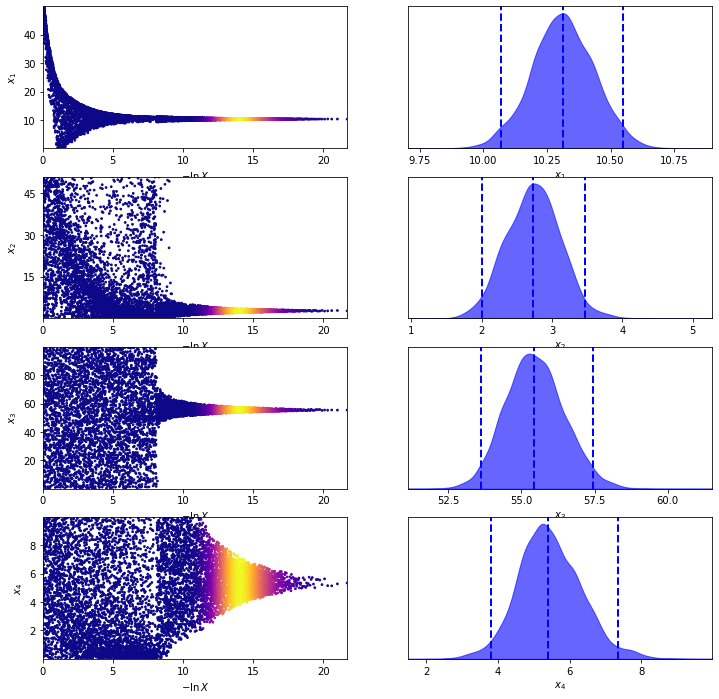

In [390]:
tfig, taxes = dyplot.traceplot(sresults_2)

Again, I want to get to the posterior samples:

In [383]:
weights_2 = np.exp(sresults_2['logwt'] - sresults_2['logz'][-1])
postsamples_2 = resample_equal(sresults_2.samples, weights_2)

In [384]:
print('Number of posterior samples (using static sampler) is {}'.format(postsamples_2.shape[0]))

Number of posterior samples (using static sampler) is 8252


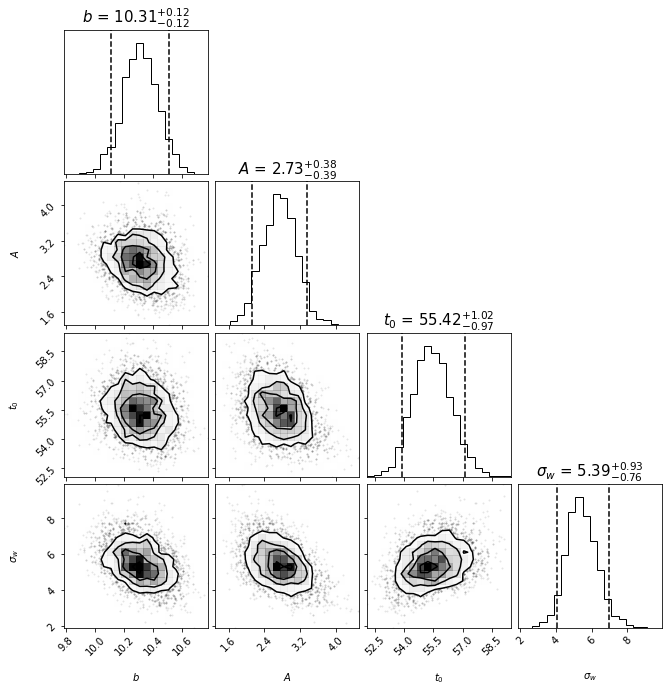

In [385]:
fig = corner.corner(
    postsamples_2, labels=[r"$b$", r"$A$", r"$t_0$", r"$\sigma_w$"], quantiles=[0.05, 0.95], show_titles=True, title_kwargs={"fontsize": 15}
);

Interesting. What am I seeing though? All the parameters seem to be uncorrelated.

Which model is the best?

As I intended I need to compute the evidence ratio, so here it is: 

In [395]:
O_12 = np.exp(logZdynesty) / np.exp(logZdynesty_2)

In [396]:
print("Bayesian factor:", O_12)

Bayesian factor: 41.10267532928421
